# Load Libraries

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from joblib import dump, load
from imblearn.over_sampling import SMOTE


In [2]:
mhs = pd.read_csv('../MHS.csv')
mhs = mhs.drop(columns=['pembimbing_tugas_akhir'])

sa = pd.read_csv('../SA.csv')
krs = pd.read_csv('../KRS.csv')

point_mapping = {
    'Lokal': 1,
    'Provinsi': 3,
    'Nasional': 5,
    'International': 10
}

# Apply mapping
sa['points'] = sa['tingkat_kegiatan'].str.lower().map(point_mapping).fillna(1)

# Calculate total points for each student
sa_points = sa.groupby('npm_mahasiswa')['points'].sum().reset_index()
sa_points.rename(columns={'points': 'total_activity_points'}, inplace=True)

# Calculate attendance percentage per course
krs['attendance_percentage'] = (krs['total_hadir'] / krs['total_pertemuan']) * 100

total_sks = krs.groupby('npm_mahasiswa')['sks_matakuliah'].sum().reset_index()
total_sks.rename(columns={'sks_matakuliah': 'total_sks'}, inplace=True)

attendance = krs.groupby('npm_mahasiswa')['attendance_percentage'].mean().reset_index()
attendance.rename(columns={'attendance_percentage': 'attendance_rate'}, inplace=True)

In [3]:
# Merge SA and KRS aggregated data with MHS.csv

data = mhs.merge(sa_points, on='npm_mahasiswa', how='left')
data = data.merge(total_sks, on='npm_mahasiswa', how='left')
data = data.merge(attendance, on='npm_mahasiswa', how='left')

data.fillna(0, inplace=True)

# Fill missing values (e.g., students with no activities or KRS data)
data['attendance_rate'] = data['attendance_rate'].fillna(0)
data['ipk_mahasiswa'] = data['ipk_mahasiswa'].fillna(0)

data.dropna(inplace=True)

# data['attendance_rate'] = data['total_hadir'] / data['total_pertemuan']
data['activity_count'] = sa.groupby('npm_mahasiswa')['nama_kegiatan'].transform('count')
data['activity_count'] = data['activity_count'].fillna(0)


In [4]:
data.head()

,npm_mahasiswa,nama_mahasiswa,prodi_mahasiswa,angkatan_mahasiswa,ipk_mahasiswa,status_mahasiswa,total_activity_points,total_sks,attendance_rate,activity_count
0,1931173,Celine Te,Sistem Informasi,2019,3.87,Lulus,18.0,145.0,94.841270,23
1,1931001,Rido Renando,Sistem Informasi,2019,3.72,Lulus,26.0,145.0,96.428571,61
2,1931009,Richie Marlon,Sistem Informasi,2019,3.90,Lulus,15.0,145.0,88.571429,61
3,1931083,Elvin Whang,Sistem Informasi,2019,3.68,Lulus,9.0,145.0,93.831169,53
4,2031001,Robin Sunjaya,Sistem Informasi,2020,3.88,Aktif,31.0,149.0,90.527950,53


# Preprocessing


In [5]:
# X = data[['ipk_mahasiswa', 'attendance_rate', 'total_activity_points','activity_count']]
X = data[['ipk_mahasiswa', 'attendance_rate', 'total_activity_points','activity_count','angkatan_mahasiswa']]
y = (data['status_mahasiswa'].isin(['Drop-out (putus studi)', 'Keluar'])).astype(int)

print(y.value_counts())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

status_mahasiswa
0    640
1     33
Name: count, dtype: int64


# Train Model

In [12]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

# Train the model on the resampled data
model = RandomForestClassifier(
    random_state=42,
    n_jobs=3,
    class_weight={1: 5},
)
model.fit(X_resampled, y_resampled)



# model = RandomForestClassifier(
#     random_state=42,
#     n_jobs=3,
#     class_weight='balanced',
# )
# model.fit(X_train_scaled, y_train)

['do-predict.joblib']

In [ ]:

joblib.dump(model, 'do-predict.joblib')

# Evaluate Model

Accuracy: 0.95
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       128
           1       0.00      0.00      0.00         7

    accuracy                           0.95       135
   macro avg       0.47      0.50      0.49       135
weighted avg       0.90      0.95      0.92       135

ROC-AUC: 0.91


c:\Users\Asus\Desktop\AI\test-profiler-ml\venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\Asus\Desktop\AI\test-profiler-ml\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Asus\Desktop\AI\test-profiler-ml\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Asus\Desktop\AI\test-profiler-ml\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetr

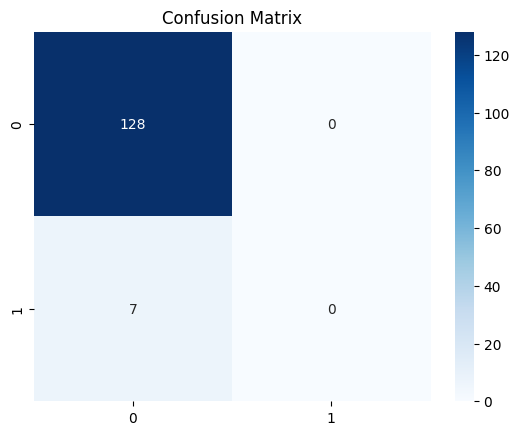

In [13]:
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Classification Report
print(classification_report(y_test, y_pred))

# ROC-AUC (only for models that output probabilities)
if hasattr(model, "predict_proba"):
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])
    print(f"ROC-AUC: {roc_auc:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Visualize Feature Importance

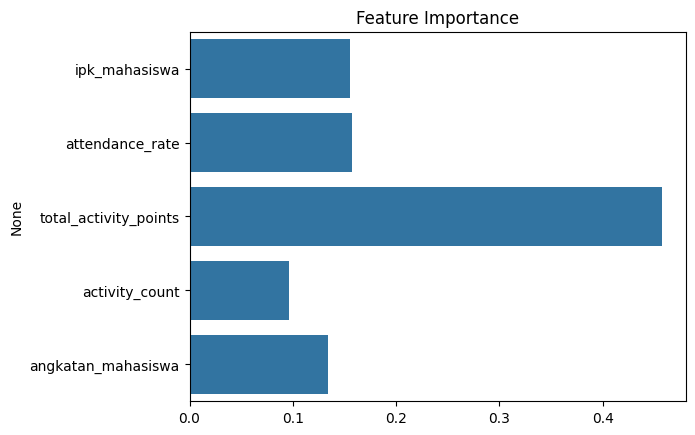

In [8]:
# Plot feature importance
importances = model.feature_importances_
feature_names = X.columns
sns.barplot(x=importances, y=feature_names)
plt.title('Feature Importance')
plt.show()

# Test Model

In [18]:
model = load('do-predict.joblib')

def predict_do(npm, data):

    data_mhs = data[data['npm_mahasiswa'] == npm]

    if data_mhs.empty:
        return f"Data {npm} tidak ditemukan."
    
    nama_mahasiswa = data_mhs['nama_mahasiswa'].values[0]

    features = data_mhs[['ipk_mahasiswa', 'attendance_rate', 'total_activity_points','activity_count','angkatan_mahasiswa']].values

    prediction = model.predict(features)

    # Map the prediction to a human-readable status (assuming binary classification)
    status_mapping = {0: 'Aktif', 1: 'Drop-out (putus studi)'}
    predicted_status = status_mapping.get(prediction[0], 'Status tidak diketahui')

    # Return the result
    return f"Mahasiswa {nama_mahasiswa} (NPM: {npm}) diprediksi memiliki status: {predicted_status}."


In [22]:
test = predict_do(2231067, data)
print(test)

Mahasiswa Jefriyanto Chandra (NPM: 2231067) diprediksi memiliki status: Aktif.


# GridSearch

In [9]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='roc_auc',
    verbose=2,
    n_jobs=3,
)

grid_search.fit(X_train_scaled, y_train)
best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


# Handle Imbalance

In [10]:
print(X.isnull().sum())

ipk_mahasiswa            0
attendance_rate          0
total_activity_points    0
activity_count           0
angkatan_mahasiswa       0
dtype: int64


In [11]:
model = RandomForestClassifier(class_weight='balanced', random_state=42)

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)